In [1]:
import imageio as img
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy import signal
from scipy import ndimage
import matplotlib


(1195, 1857, 4)
(1195, 1857)


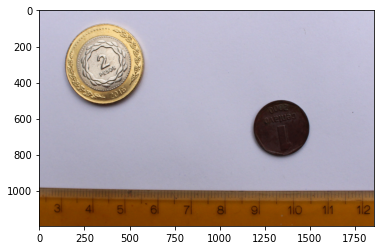

In [2]:
#matplotlib.use('Qt5Agg')

im = img.imread('vil_metal.png')

#Mostrar imagen original
print(im.shape)
print(im[:,:,0].shape)
plt.imshow(im)
plt.show()

In [9]:
#función para plotear más rápido:

def plotear_con_coord(im, punto=None):
    plt.imshow(im)
    xlen = im.shape[1]
    ylen = im.shape[0]
    if punto:
        xpunto = punto[0]
        ypunto = punto[1]
        plt.plot([0,xlen],[ypunto,ypunto])
        plt.plot([xpunto,xpunto], [0,ylen])
    plt.xlim([0,xlen])
    plt.ylim([ylen,0])
    plt.show()
    return 

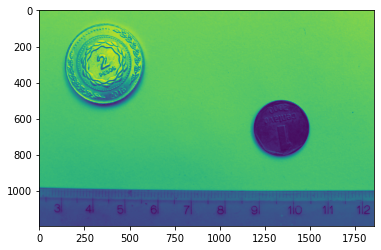

In [4]:
#Definir la matriz que hará la convolución
kernel = [[1,2,1],[0,0,0],[-1,-2,-1]]

#componente verde de la imagen convolucionada (detección de bordes horizontal)
H = signal.convolve2d(im[:,:,1], kernel)


#Mostrar componente verde de la imagen
plt.imshow(im[:,:,1])
plt.show()

(1197, 1859)


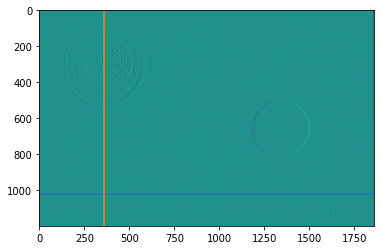

'\nplt.plot(np.arange(0,1859), np.ones(1859)*posicion_de_calibracion_y)\nplt.plot(np.ones(1197)*posicion_de_calibracion_x, np.arange(0,1197))\nplt.xlim([0,1859])\nplt.ylim([1197,0])\nplt.show()'

In [10]:
#componente verde de la imagen convolucionada (detección de bordes vertical)
V = signal.convolve2d(im[:,:,1], np.transpose(kernel))

print(V.shape)

#Mostrar imagen con detección de bordes vertical y dos rectas, una horizontal y otra vertical
#La intersección de las rectas muestra alrededor de qué puntos de la regla voy a calibrar

posicion_de_calibracion_y = 1022
posicion_de_calibracion_x = 360
plotear_con_coord(V, punto=[posicion_de_calibracion_x, posicion_de_calibracion_y])


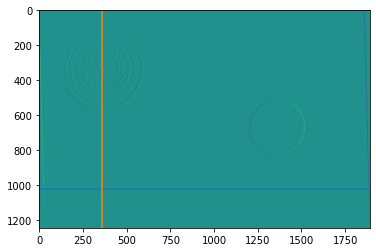

In [12]:
#Se ve que las lineas de la regla no estan perfectamente alineadas con la recta vertical
#Rotar la imagen en el ángulo necesario:
angulo = 1.5
V_rotada = ndimage.rotate(V, angulo)
plotear_con_coord(V_rotada, punto=[posicion_de_calibracion_x, posicion_de_calibracion_y])

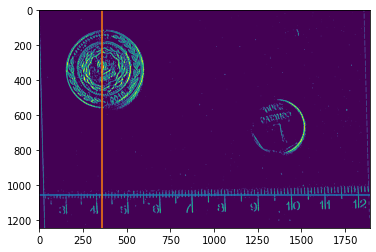

In [13]:
#Creamos imagen binarizada y modifico la posición de la recta horizontal:
modificacion = 35
posicion_de_calibracion_y = posicion_de_calibracion_y + modificacion
im_bin = np.zeros(V_rotada.shape)
filtro = (V_rotada > 25)
im_bin[filtro] = 1

#Mostramos imagen binarizada más el rango del plot que vamos a utilizar para calibrar
plotear_con_coord(im_bin, punto=[posicion_de_calibracion_x, posicion_de_calibracion_y])

Len puntos:  18
10.331488509382245 ± 79.7914469183899


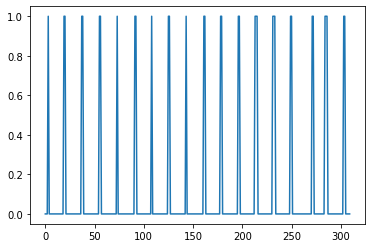

In [14]:
matplotlib.use('Qt5Agg')

#Hacemos un ploteo de los valores de la imagen para la recta horizontal entre los valores de x
#tales que la rotación siga valiendo. Además extraemos los puntos necesarios del plot.
#Todos los puntos se seleccionan a mano y precisamente (método 1):
vals_a_yfijo = im_bin[posicion_de_calibracion_y, 220:530]
plt.plot(vals_a_yfijo)
puntos = plt.ginput(18, timeout=60)
print("Len puntos: ",len(puntos))
puntos = np.array(puntos)
puntos_x = puntos[:,0]

#Calculamos el promedio de distancia entre los puntos y la desviación estandar
#correspondiente, con eso definimos una escala pixel/mm para así medir las distancias.
diff = np.diff(puntos_x)
escala = np.mean(diff)
escala_error = np.std(diff)
print(escala, "±", 2*escala_error)


Len puntos2:  18
17.65185259163088


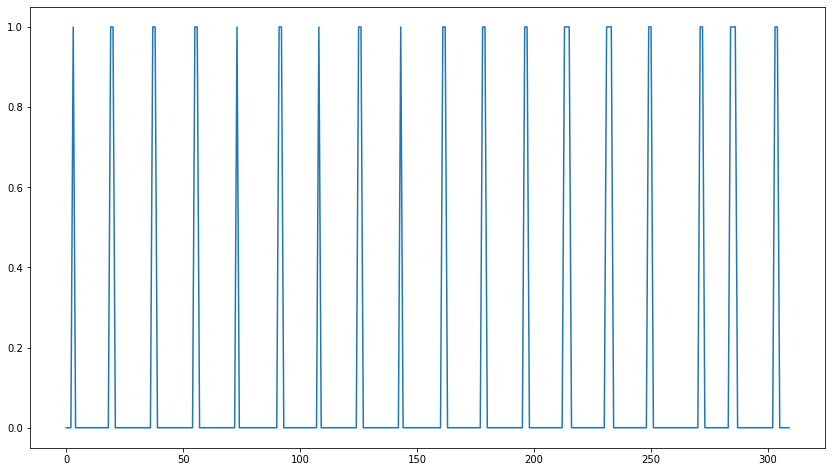

In [16]:
#Voy a hacer lo mismo perocon otro método. Se cuentan todos los puntos a manos pero sólo es 
#necesario tomar precisamente el primero y el último:
vals_a_yfijo = im_bin[posicion_de_calibracion_y, 220:530]
plt.plot(vals_a_yfijo)
puntos2 = plt.ginput(18, timeout=60)
print("Len puntos2: ",len(puntos2))
puntos2 = np.array(puntos2)
puntos2_x = puntos2[:,0]

#Calculamos el promedio de distancia entre el punto inicial y el final, luego dividimos por
#la cantidad de puntos para obtener una distancia promedio.
#¿Cómo calculo el error de esto?
diff2 = puntos2_x[-1] - puntos2_x[0]
escala2 = diff2/(len(puntos2_x)-1)
#escala_error = np.std(diff)??
print(escala2) #, "±", escala_error)

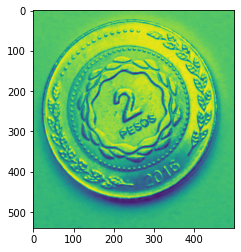

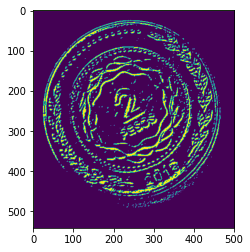

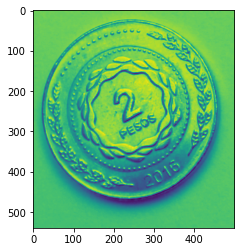

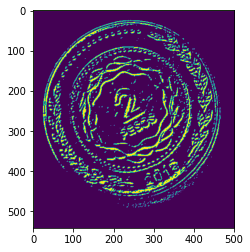

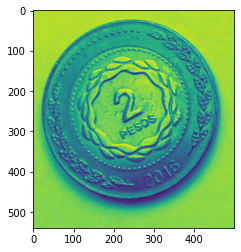

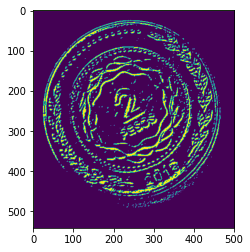

In [82]:
mon_2 = ndimage.rotate(im,angulo)[90:630,130:630]
%matplotlib inline
#mon_2 = mon_2/255
#mon_2 = mon_2*np.log(mon_2)

for i, color in enumerate(["red","green","blue"]):
    plt.imshow(mon_2[:,:,i], label=color)
    plt.show()
    filtro = (mon_2_bor > 70)
    mon_2_bin = np.zeros(mon_2_bor.shape)
    mon_2_bin[filtro] = 1
    plt.imshow(mon_2_bin)
    plt.show()
    pass

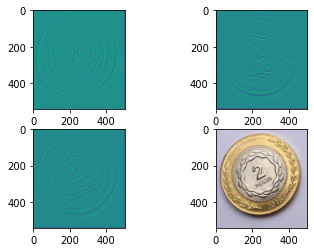

In [89]:
#hago un poco de procesamiento sobre la imagen de la moneda para identificar mejor los bordes:
mon_2 = ndimage.rotate(im,angulo)[90:630,130:630]
mon_2_verde = mon_2[:,:,1]
mon_2_vert = signal.convolve2d(mon_2_verde, np.transpose(kernel))
mon_2_hor = signal.convolve2d(mon_2_verde, kernel)
mon_2_bor = mon_2_vert + mon_2_hor

#matplotlib.use('Qt5Agg')
fig, axs = plt.subplots(2,2)
axs[0][0].imshow(mon_2_vert)
axs[0][1].imshow(mon_2_hor)
axs[1][0].imshow(mon_2_bor)
axs[1][1].imshow(mon_2)



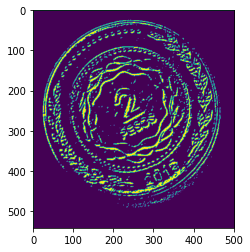

In [50]:
filtro = (mon_2_bor > 70)
mon_2_bin = np.zeros(mon_2_bor.shape)
mon_2_bin[filtro] = 1

plotear_con_coord(mon_2_bin)

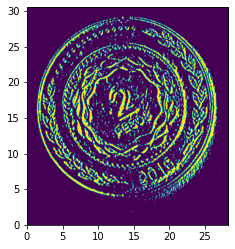

In [17]:
#ahora normalizamos el gráfico. pero lo voy a hacer para la región cercana a donde calibré:
moneda_de_2 = im_bin[90:630,130:630]
eje_x = np.arange(moneda_de_2.shape[1])/escala2
eje_y = np.arange(moneda_de_2.shape[0])/escala2

plt.imshow(moneda_de_2, extent=[eje_x.min(), eje_x.max(), eje_y.min(), eje_y.max()])
plt.show()

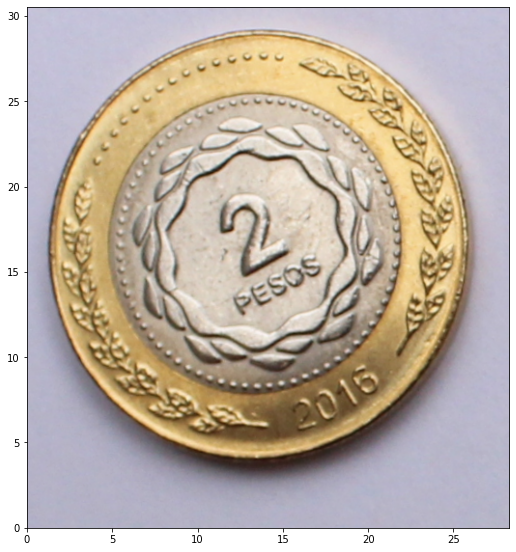

In [95]:
#mejor elijo los bordes desde la foto original:
matplotlib.use("Qt5Agg")
plt.imshow(mon_2, extent=[eje_x.min(), eje_x.max(), eje_y.min(), eje_y.max()])
extremos_moneda = plt.ginput(4, timeout=60)
arriba, abajo, izquierda, derecha = extremos_moneda
plt.show()

In [97]:
print(derecha[0]-izquierda[0], arriba[1]-abajo[1])

24.559326552525132 25.43853872027661
